In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy

#Preprocessing
from category_encoders import TargetEncoder
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline



#Model Selection
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.model_selection import train_test_split

#Metrics
from sklearn.metrics import balanced_accuracy_score, accuracy_score, confusion_matrix

# Models
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.ensemble import  RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, StackingClassifier
from xgboost import XGBClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.svm import SVC, LinearSVC

#RegressionModels
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor


#Oversample 
from imblearn.over_sampling import RandomOverSampler, SMOTENC



#Pipeline
from sklearn.pipeline import Pipeline

# Deep
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.neural_network import MLPClassifier


#other
import os
import warnings
warnings.filterwarnings("ignore")

In [4]:

os.chdir(r'C:\Users\danie\OneDrive\Desktop\Fall2023\ELEC478\Competition\neuron-synapse-prediction')
 
#load in training data on each potential synapse
data = pd.read_csv("./train_data.csv")

#load in additional features for each neuron
feature_weights = pd.read_csv("./feature_weights.csv")
morph_embeddings = pd.read_csv("./morph_embeddings.csv")

In [5]:
print("Main Dataframe Size:",data.shape)
print("\nMain Dataframe:")
data.info()

print("\nFeature Weights Size:",feature_weights.shape)
print("\nFeature Weights:")
feature_weights.info(verbose=False)

print("\nMorphological Embeddings Size:",morph_embeddings.shape)
print("\nMorphological Embeddings:")
morph_embeddings.info(verbose=False)

Main Dataframe Size: (185832, 30)

Main Dataframe:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 185832 entries, 0 to 185831
Data columns (total 30 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   ID                              185832 non-null  int64  
 1   axonal_coor_x                   185832 non-null  int64  
 2   axonal_coor_y                   185832 non-null  int64  
 3   axonal_coor_z                   185832 non-null  int64  
 4   dendritic_coor_x                185832 non-null  int64  
 5   dendritic_coor_y                185832 non-null  int64  
 6   dendritic_coor_z                185832 non-null  int64  
 7   adp_dist                        185832 non-null  float64
 8   post_skeletal_distance_to_soma  185832 non-null  float64
 9   pre_skeletal_distance_to_soma   185832 non-null  float64
 10  pre_oracle                      185832 non-null  float64
 11  pre_test_score             

In [6]:
# join all feature_weight_i columns into a single np.array column
feature_weights["feature_weights"] = (
    feature_weights.filter(regex="feature_weight_")
    .sort_index(axis=1)
    .apply(lambda x: np.array(x), axis=1)
)
# delete the feature_weight_i columns
feature_weights.drop(
    feature_weights.filter(regex="feature_weight_").columns, axis=1, inplace=True
)

# join all morph_embed_i columns into a single np.array column
morph_embeddings["morph_embeddings"] = (
    morph_embeddings.filter(regex="morph_emb_")
    .sort_index(axis=1)
    .apply(lambda x: np.array(x), axis=1)
)
# delete the morph_embed_i columns
morph_embeddings.drop(
    morph_embeddings.filter(regex="morph_emb_").columns, axis=1, inplace=True
)

In [7]:
data = (
    data.merge(
        feature_weights.rename(columns=lambda x: "pre_" + x), 
        how="left", 
        validate="m:1",
        copy=False,
    )
    .merge(
        feature_weights.rename(columns=lambda x: "post_" + x),
        how="left",
        validate="m:1",
        copy=False,
    )
    .merge(
        morph_embeddings.rename(columns=lambda x: "pre_" + x),
        how="left",
        validate="m:1",
        copy=False,
    )
    .merge(
        morph_embeddings.rename(columns=lambda x: "post_" + x),
        how="left",
        validate="m:1",
        copy=False,
    )
)

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 185832 entries, 0 to 185831
Data columns (total 34 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   ID                              185832 non-null  int64  
 1   axonal_coor_x                   185832 non-null  int64  
 2   axonal_coor_y                   185832 non-null  int64  
 3   axonal_coor_z                   185832 non-null  int64  
 4   dendritic_coor_x                185832 non-null  int64  
 5   dendritic_coor_y                185832 non-null  int64  
 6   dendritic_coor_z                185832 non-null  int64  
 7   adp_dist                        185832 non-null  float64
 8   post_skeletal_distance_to_soma  185832 non-null  float64
 9   pre_skeletal_distance_to_soma   185832 non-null  float64
 10  pre_oracle                      185832 non-null  float64
 11  pre_test_score                  185832 non-null  float64
 12  pre_rf_x        

In [9]:
#cosine similarity function
def row_feature_similarity(row):
    pre = row["pre_feature_weights"]
    post = row["post_feature_weights"]
    return (pre * post).sum() / (np.linalg.norm(pre) * np.linalg.norm(post))

In [10]:
#cosine similarity function
def row_morph_similarity(row):
    pre = row["pre_morph_embeddings"]
    post = row["post_morph_embeddings"]
    return (pre * post).sum() / (np.linalg.norm(pre) * np.linalg.norm(post))

In [11]:
def feature_engineering(data, me_similarity = True):
    # compute the cosine similarity between the pre- and post- feature weights
    data["fw_similarity"] = data.apply(row_feature_similarity, axis=1)  

    if me_similarity:
        data['me_similarity'] = data.apply(row_morph_similarity, axis=1)  
        
    data['log_adp_dist'] = np.log(data['adp_dist'])    

    #Oracle 
    data['oracle_sq'] = data['pre_oracle'] * data['post_oracle']

    #Test Score
    data['test_score_sq'] = data['pre_test_score'] * data['post_test_score']

    # generate projection group as pre->post
    data["projection_group"] = (
        data["pre_brain_area"].astype(str)
        + "_to_"
        + data["post_brain_area"].astype(str)
    )


In [12]:
feature_engineering(data)

In [13]:
data.isna().sum()

ID                                    0
axonal_coor_x                         0
axonal_coor_y                         0
axonal_coor_z                         0
dendritic_coor_x                      0
dendritic_coor_y                      0
dendritic_coor_z                      0
adp_dist                              0
post_skeletal_distance_to_soma        0
pre_skeletal_distance_to_soma         0
pre_oracle                            0
pre_test_score                        0
pre_rf_x                              0
pre_rf_y                              0
post_oracle                           0
post_test_score                       0
post_rf_x                             0
post_rf_y                             0
compartment                           0
pre_brain_area                        0
post_brain_area                       0
pre_nucleus_x                         0
pre_nucleus_y                         0
pre_nucleus_z                         0
post_nucleus_x                        0


In [14]:
numerical_features=['adp_dist', 'post_skeletal_distance_to_soma', 'pre_skeletal_distance_to_soma',
       'fw_similarity', 'me_similarity', 'pre_oracle', 'post_oracle', 'pre_test_score', 'post_test_score']

categorical_features = ['compartment', 'projection_group']

features = numerical_features + categorical_features

target = ['connected']

In [15]:
data[features].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 185832 entries, 0 to 185831
Data columns (total 11 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   adp_dist                        185832 non-null  float64
 1   post_skeletal_distance_to_soma  185832 non-null  float64
 2   pre_skeletal_distance_to_soma   185832 non-null  float64
 3   fw_similarity                   185832 non-null  float64
 4   me_similarity                   138123 non-null  float64
 5   pre_oracle                      185832 non-null  float64
 6   post_oracle                     185832 non-null  float64
 7   pre_test_score                  185832 non-null  float64
 8   post_test_score                 185832 non-null  float64
 9   compartment                     185832 non-null  object 
 10  projection_group                185832 non-null  object 
dtypes: float64(9), object(2)
memory usage: 17.0+ MB


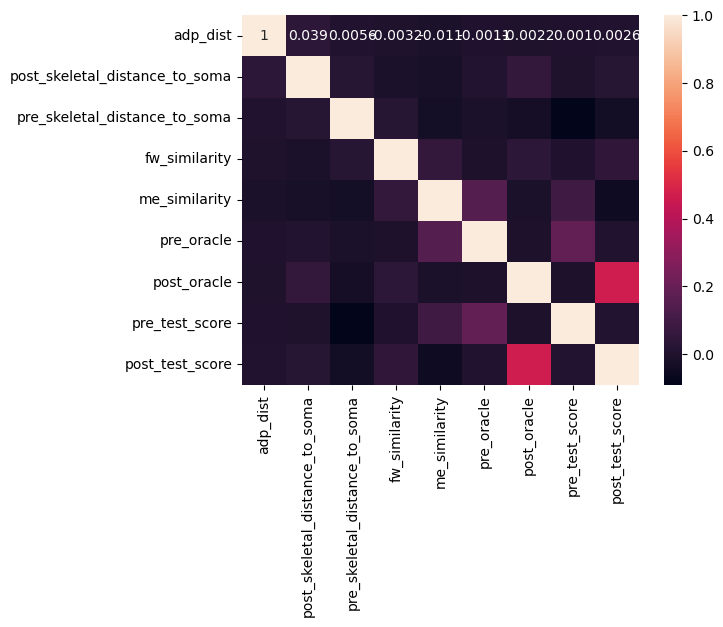

In [16]:
sns.heatmap(data[features].corr(), annot=True)
plt.show()

Either impute values or remove column 

In [17]:
# split data
X_data = data[features]
y_data = data[target]

#Get Training Set
X_train, X_temp, y_train, y_temp = train_test_split(X_data, y_data, test_size=0.3, random_state=42)

# Second, split the temporary set into validation and test sets
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Combine training and validation sets for tuned model training
X_train_combined = pd.concat([X_train, X_valid], axis=0)
y_train_combined = pd.concat([y_train, y_valid], axis=0)

In [18]:
def impute_missing(df, target_column,regressor, categorical_encoder):
   
    # Split the data into features and target
    X = df.drop(columns=[target_column])
    y = df[target_column]

    # Identify missing values in the target column
    missing_mask = y.isnull()


    numerical_features_copy  = numerical_features.copy()
    numerical_features_copy.remove(target_column)
    # Define the column transformer for preprocessing
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', MinMaxScaler(), numerical_features_copy),  # Apply MinMaxScaler to numerical features
            ('cat', categorical_encoder, categorical_features)    # Apply OneHotEncoder to categorical features
        ])

    # Create the pipeline with RandomForestRegressor for imputation
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', regressor)
    ])

    # Fit the pipeline on the observed values
    pipeline.fit(X[~missing_mask], y[~missing_mask])

    # Predict missing values
    y_imputed = y.copy()
    y_imputed[missing_mask] = pipeline.predict(X[missing_mask])

    # Create a new DataFrame with imputed values
    df_imputed = df.copy()
    df_imputed[target_column] = y_imputed

    return df_imputed

In [71]:
#delete me_similarity column
X_train_nme = X_train.drop(columns=['me_similarity'], inplace = False)
X_valid_nme = X_valid.drop(columns=['me_similarity'], inplace = False)
X_test_nme = X_test.drop(columns=['me_similarity'], inplace = False)

In [19]:
#Linear regression imputation

X_data_lr =  impute_missing(X_data, 'me_similarity', LinearRegression(), OneHotEncoder())

X_train_lr = impute_missing(X_train, 'me_similarity', LinearRegression(), OneHotEncoder())
X_valid_lr = impute_missing(X_valid, 'me_similarity', LinearRegression(), OneHotEncoder())
X_test_lr = impute_missing(X_test, 'me_similarity', LinearRegression(),  OneHotEncoder())

X_train_combined_lr = impute_missing(X_train_combined, 'me_similarity', LinearRegression(), OneHotEncoder())

In [57]:
#RandomForest regression imputation 
X_train_rf = impute_missing(X_train, 'me_similarity', RandomForestRegressor(random_state=42, n_estimators= 100, max_depth= 5),TargetEncoder())
X_valid_rf = impute_missing(X_valid, 'me_similarity', RandomForestRegressor(random_state=42, n_estimators= 100, max_depth= 5),TargetEncoder())
X_test_rf = impute_missing(X_test, 'me_similarity', RandomForestRegressor(random_state=42, n_estimators= 100, max_depth= 5),TargetEncoder())

X_train_combined_rf = impute_missing(X_train_combined, 'me_similarity', RandomForestRegressor(random_state=42, n_estimators= 500, max_depth= 5),TargetEncoder())


# LASSO for Feature Selection 

In [20]:
# Lasso with OneHotEncoding and me_similarity linear regression imputation


# Define the column transformer for preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('num', MinMaxScaler(), numerical_features),
        ('cat', OneHotEncoder(), categorical_features)
    ])

X_pre = preprocessor.fit_transform(X_train_lr)

#Oversample
oversampler = RandomOverSampler(random_state=42)
X_train_resampled, y_train_resampled = oversampler.fit_resample(X_pre, y_train)
   
# Define the pipeline with preprocessing, oversampling, and logistic regression
lasso = LogisticRegression(random_state=42, penalty='l1', solver='saga')


lasso.fit(X_train_resampled, y_train_resampled)
y_pred = lasso.predict_proba(preprocessor.transform(X_valid_lr))[:, 1]

print(round(balanced_accuracy_score(y_valid, y_pred > .5), 3))



0.765


In [29]:
# Lasso with OneHotEncoding and me_similarity RandomForest Regression imputation


# Define the column transformer for preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('num', MinMaxScaler(), numerical_features),
        ('cat', OneHotEncoder(), categorical_features)
    ])

X_pre = preprocessor.fit_transform(X_train_rf)

#Oversample
oversampler = RandomOverSampler(random_state=42)
X_train_resampled, y_train_resampled = oversampler.fit_resample(X_pre, y_train)
   
# Define the pipeline with preprocessing, oversampling, and logistic regression
lasso = LogisticRegression(random_state=42, penalty='l1', solver='saga')


lasso.fit(X_train_resampled, y_train_resampled)
y_pred = lasso.predict_proba(preprocessor.transform(X_valid_rf))[:, 1]

print(round(balanced_accuracy_score(y_valid, y_pred > .5), 3))


NameError: name 'X_train_rf' is not defined

In [56]:
# Lasso with OneHotEncoding and no me_similarity

# Define the column transformer for preprocessing
numerical_features_nme = numerical_features.copy()
numerical_features_nme.remove('me_similarity')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', MinMaxScaler(), numerical_features_nme),
        ('cat', OneHotEncoder(), categorical_features)
    ])



X_pre = preprocessor.fit_transform(X_train_nme)

#Oversample
oversampler = RandomOverSampler(random_state=42)
X_train_resampled, y_train_resampled = oversampler.fit_resample(X_pre, y_train)
   
# Define the pipeline with preprocessing, oversampling, and logistic regression
lasso = LogisticRegression(random_state=42, penalty='l1', solver='saga')


lasso.fit(X_train_resampled, y_train_resampled)
y_pred = lasso.predict_proba(preprocessor.transform(X_valid_nme))[:, 1]

print(round(balanced_accuracy_score(y_valid, y_pred > .5), 3))


0.744


In [77]:
# Lasso with TargetEncoding and me_similarity linear regression imputation


# Define the column transformer for preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('num', MinMaxScaler(), numerical_features),
        ('cat', TargetEncoder(), categorical_features)
    ])

X_pre = preprocessor.fit_transform(X_train_lr, y_train)

#Oversample
oversampler = RandomOverSampler(random_state=42)
X_train_resampled, y_train_resampled = oversampler.fit_resample(X_pre, y_train)
   
# Define the pipeline with preprocessing, oversampling, and logistic regression
lasso = LogisticRegression(random_state=42, penalty='l1', solver='saga')


lasso.fit(X_train_resampled, y_train_resampled)
y_pred = lasso.predict_proba(preprocessor.transform(X_valid_lr))[:, 1]

print(round(balanced_accuracy_score(y_valid, y_pred > .5), 3))


0.758


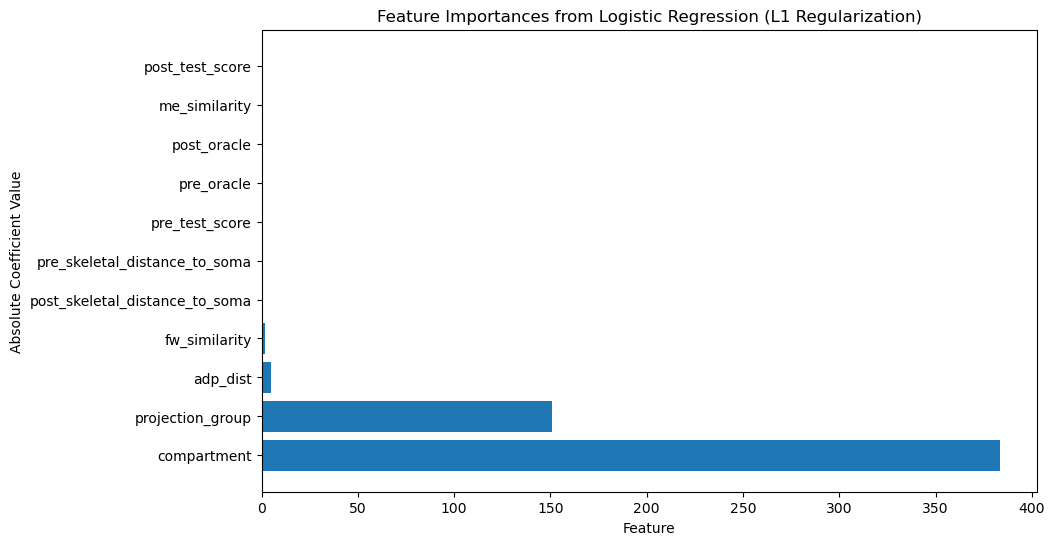

In [76]:
# Get feature importances (absolute values of coefficients for L1 regularization)
feature_importances = np.abs(lasso.coef_[0])

# Sort the features based on their importance
sorted_indices = np.argsort(feature_importances)[::-1]
sorted_feature_importances = feature_importances[sorted_indices]

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.barh(range(X_train.shape[1]), sorted_feature_importances, align="center")
plt.yticks(range(X_train.shape[1]), np.array(X_train.columns)[sorted_indices])
plt.xlabel("Feature")
plt.ylabel("Absolute Coefficient Value")
plt.title("Feature Importances from Logistic Regression (L1 Regularization)")
plt.show()

In [80]:
# Lasso with OneHotEncoding and me_similarity linear regression imputation


# Define the column transformer for preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('num', MinMaxScaler(), numerical_features),
        ('cat', OneHotEncoder(), categorical_features)
    ])

X_pre = preprocessor.fit_transform(X_train_combined_lr)

#Oversample
oversampler = RandomOverSampler(random_state=42)
X_train_resampled, y_train_resampled = oversampler.fit_resample(X_pre, y_train_combined)
   
# Define the pipeline with preprocessing, oversampling, and logistic regression
 
cv = StratifiedKFold(n_splits=5)
param_grid = {'C': np.logspace(-2,1,6),
              'l1_ratio': [0,0.25,0.5,0.75,1]}


grid = GridSearchCV(LogisticRegression(random_state=42, penalty= 'elasticnet', solver = 'saga'),
                     param_grid = param_grid, cv = cv , scoring = 'balanced_accuracy' )
grid.fit(X_train_resampled, y_train_resampled)

print(grid.best_params_)
print(grid.best_score_)

logistic = LogisticRegression(**grid.best_params_)


logistic.fit(X_train_resampled, y_train_resampled)
y_pred = logistic.predict_proba(preprocessor.transform(X_test_lr))[:, 1]

print(round(balanced_accuracy_score(y_test, y_pred > .5), 3))



{'C': 0.15848931924611134, 'l1_ratio': 1}
0.7797238696511701
0.796


In [59]:
# Logistic with OneHotEncoding and me_similarity random forest imputation


# Define the column transformer for preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('num', MinMaxScaler(), numerical_features),
        ('cat', OneHotEncoder(), categorical_features)
    ])

X_pre = preprocessor.fit_transform(X_train_combined_lr)

#Oversample
oversampler = RandomOverSampler(random_state=42)
X_train_resampled, y_train_resampled = oversampler.fit_resample(X_pre, y_train_combined)

    
# Logistic Regression Params from Grid Search
lasso = LogisticRegression(random_state=42, penalty='elasticnet', solver='saga', C = 0.15848931924611134, l1_ratio=1)


lasso.fit(X_train_resampled, y_train_resampled)
y_pred = lasso.predict_proba(preprocessor.transform(X_test_lr))[:, 1]

print(round(balanced_accuracy_score(y_test, y_pred > .5), 3))


0.796


In [78]:
# Logistic with OneHotEncoding and me_similarity linear regression imputation


# Define the column transformer for preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('num', MinMaxScaler(), numerical_features),
        ('cat', OneHotEncoder(), categorical_features)
    ])

X_pre = preprocessor.fit_transform(X_train_combined_lr)

#Oversample
oversampler = RandomOverSampler(random_state=42)
X_train_resampled, y_train_resampled = oversampler.fit_resample(X_pre, y_train_combined)

    
# Logistic Regression Params from Grid Search
lasso = LogisticRegression(random_state=42, penalty='elasticnet', solver='saga', C = 0.01, l1_ratio=0.5)


lasso.fit(X_train_resampled, y_train_resampled)
y_pred = lasso.predict_proba(preprocessor.transform(X_test_lr))[:, 1]

print(round(balanced_accuracy_score(y_test, y_pred > .5), 3))


0.799


In [58]:
# Logistic with OneHotEncoding and me_similarity linear regression imputation


# Define the column transformer for preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('num', MinMaxScaler(), numerical_features),
        ('cat', OneHotEncoder(), categorical_features)
    ])

X_pre = preprocessor.fit_transform(X_train_combined_lr)

#Oversample
oversampler = RandomOverSampler(random_state=42)
X_train_resampled, y_train_resampled = oversampler.fit_resample(X_pre, y_train_combined)

    
# Logistic Regression Params from Grid Search
lasso = LogisticRegression(random_state=42, penalty='elasticnet', solver='saga', C = 0.01, l1_ratio=0.5)


lasso.fit(X_train_resampled, y_train_resampled)
y_pred = lasso.predict_proba(preprocessor.transform(X_test_lr))[:, 1]

print(round(balanced_accuracy_score(y_test, y_pred > .5), 3))

0.799


In [ ]:
# Lasso with Target and me_similarity random forest imputation


# Define the column transformer for preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('num', MinMaxScaler(), numerical_features),
        ('cat', TargetEncoder(), categorical_features)
    ])

X_pre = preprocessor.fit_transform(X_train_combined_rf, y_train_combined)

#Oversample
oversampler = RandomOverSampler(random_state=42)
X_train_resampled, y_train_resampled = oversampler.fit_resample(X_pre, y_train_combined)

    
# Define the pipeline with preprocessing, oversampling, and logistic regression
lasso = LogisticRegression(random_state=42, penalty='l1', solver='saga')


lasso.fit(X_train_resampled, y_train_resampled)
y_pred = lasso.predict_proba(preprocessor.transform(X_test_rf))[:, 1]

print(round(balanced_accuracy_score(y_test, y_pred > .5), 3))

0.784


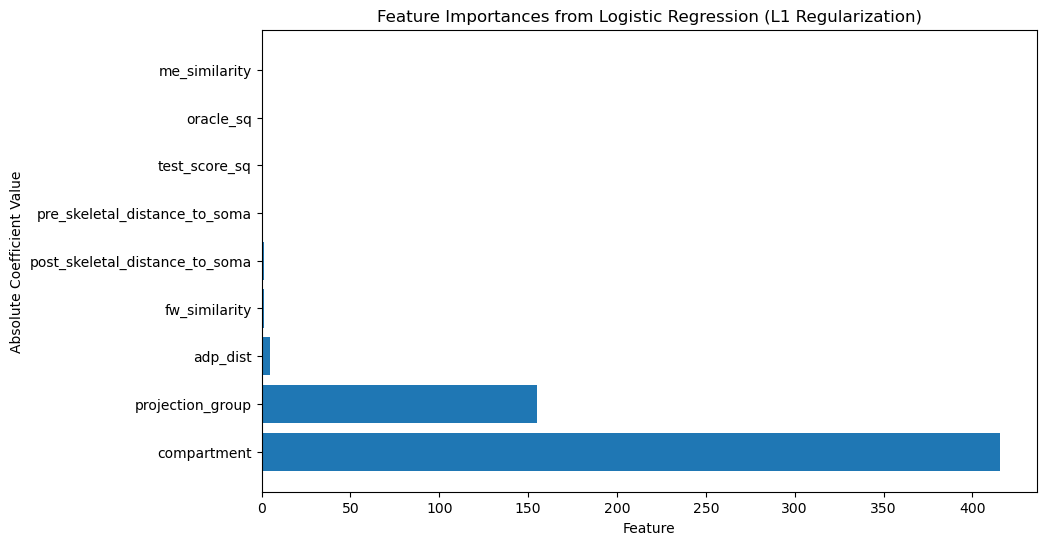

In [ ]:
# Get feature importances (absolute values of coefficients for L1 regularization)
feature_importances = np.abs(lasso.coef_[0])

# Sort the features based on their importance
sorted_indices = np.argsort(feature_importances)[::-1]
sorted_feature_importances = feature_importances[sorted_indices]

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.barh(range(X_train.shape[1]), sorted_feature_importances, align="center")
plt.yticks(range(X_train.shape[1]), np.array(X_train.columns)[sorted_indices])
plt.xlabel("Feature")
plt.ylabel("Absolute Coefficient Value")
plt.title("Feature Importances from Logistic Regression (L1 Regularization)")
plt.show()

# Random Forest for Feature Selection

In [ ]:
#   Random Forest with me_similarity imputation

In [82]:
def plot_feature_importance(model, feature_names, title="Feature Importance", rotation=45):
  
    feature_importance = model.feature_importances_
    sorted_idx = np.argsort(feature_importance)

    plt.figure(figsize=(10, 6))
    plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align="center")
    plt.yticks(range(len(sorted_idx)), np.array(feature_names)[sorted_idx])
    plt.xlabel("Feature Importance")
    plt.title(title)
    plt.xticks(rotation=rotation)
    plt.show()

In [84]:
# RandomForest with Target and me_similarity linear regression imputation

# Define the column transformer for preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('num', MinMaxScaler(), numerical_features),
        ('cat', TargetEncoder(), categorical_features)
    ])

X_pre = preprocessor.fit_transform(X_train_lr, y_train)

oversampler = RandomOverSampler(random_state=42)
X_train_resampled, y_train_resampled = oversampler.fit_resample(X_pre, y_train)


    
# Define the pipeline with preprocessing, oversampling, and logistic regression
model = RandomForestClassifier(random_state=42, n_estimators= 500, max_depth= 3)


model.fit(X_train_resampled, y_train_resampled)
y_pred = model.predict_proba(preprocessor.transform(X_valid_lr))[:, 1]

print(round(balanced_accuracy_score(y_test, y_pred > .5), 3))

0.487


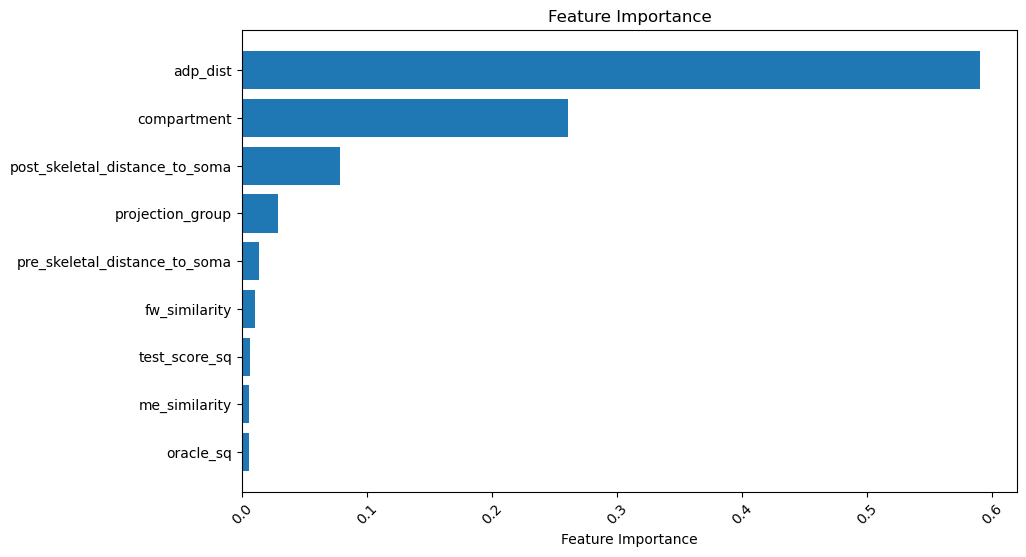

In [ ]:
plot_feature_importance(model, features, title="Feature Importance", rotation=45)

In [ ]:
# RandomForest with Target and me_similarity linear regression imputation

# Define the column transformer for preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('num', MinMaxScaler(), numerical_features),
        ('cat', OneHotEncoder(), categorical_features)
    ])

X_pre = preprocessor.fit_transform(X_train_lr)

oversampler = RandomOverSampler(random_state=42)
X_train_resampled, y_train_resampled = oversampler.fit_resample(X_pre, y_train)


model = RandomForestClassifier(random_state=42, n_estimators= 500, max_depth= 10)


model.fit(X_train_resampled, y_train_resampled)
y_pred = model.predict_proba(preprocessor.transform(X_test_lr))[:, 1]

print(round(balanced_accuracy_score(y_test, y_pred > .5), 3))

0.787


In [ ]:
#RandomForest without Encoding
# Define the column transformer for preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('num', MinMaxScaler(), numerical_features),
    ])

X_pre = preprocessor.fit_transform(X_train_lr)

oversampler = RandomOverSampler(random_state=42)
X_train_resampled, y_train_resampled = oversampler.fit_resample(X_pre, y_train)


    
# Define the pipeline with preprocessing, oversampling, and logistic regression
model = RandomForestClassifier(random_state=42, n_estimators= 500, max_depth= 10)


model.fit(X_train_resampled, y_train_resampled)
y_pred = model.predict_proba(preprocessor.transform(X_test_lr))[:, 1]

print(round(balanced_accuracy_score(y_test, y_pred > .5), 3))

0.72


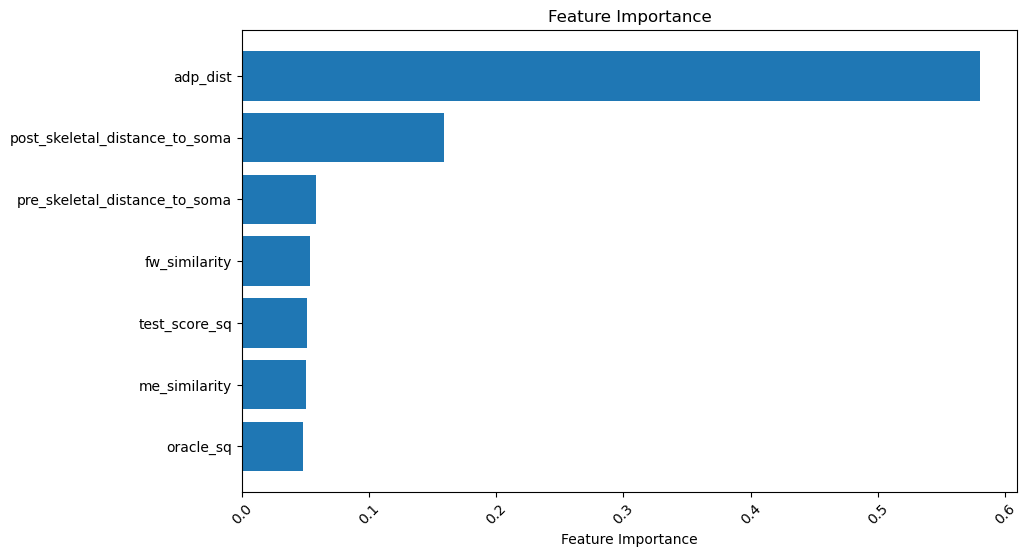

In [ ]:
plot_feature_importance(model, features, title="Feature Importance", rotation=45)

# Tuning Random Forest

## RandomOversample

In [85]:
# Random Forest with OneHotEncoding and me_similarity linear regression imputation

# Define the column transformer for preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('num', MinMaxScaler(), numerical_features),
        ('cat', OneHotEncoder(), categorical_features)
    ])

#combined data set as validation is done automatically
X_pre = preprocessor.fit_transform(X_train_combined_lr)

#Oversample
oversampler = RandomOverSampler(random_state=42)
X_train_resampled, y_train_resampled = oversampler.fit_resample(X_pre, y_train_combined)
   
# Define the pipeline with preprocessing, oversampling, and logistic regression
 
cv = StratifiedKFold(n_splits=5)
param_grid = {'n_estimators': [100, 300, 500],
              'max_depth': [5,10,20,None],
              }


grid = GridSearchCV(RandomForestClassifier(n_jobs = -1),
                     param_grid = param_grid, cv = cv, scoring = 'balanced_accuracy' )
grid.fit(X_train_resampled, y_train_resampled)

print(grid.best_params_)
print(grid.best_score_)

rf = RandomForestClassifier(**grid.best_params_)


rf.fit(X_train_resampled, y_train_resampled)
y_pred = rf.predict_proba(preprocessor.transform(X_test_lr))[:, 1]

print(round(balanced_accuracy_score(y_test, y_pred > .5), 3))


{'max_depth': None, 'n_estimators': 100}
0.999802308526242
0.502


In [88]:
pd.DataFrame(grid.cv_results_).sort_values(by = 'rank_test_score')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
9,22.375546,0.737293,0.357253,0.048401,None,100,"{'max_depth': None, 'n_estimators': 100}",0.999793,0.999825,0.999745,0.999857,0.999793,0.999802,0.000037,1
11,104.204622,2.437480,1.809677,0.091835,None,500,"{'max_depth': None, 'n_estimators': 500}",0.999777,0.999809,0.999729,0.999809,0.999857,0.999796,0.000042,2
10,63.500313,2.890248,0.996726,0.089504,None,300,"{'max_depth': None, 'n_estimators': 300}",0.999793,0.999793,0.999729,0.999793,0.999841,0.999790,0.000036,3
8,96.894693,1.370506,1.426977,0.172244,20,500,"{'max_depth': 20, 'n_estimators': 500}",0.972291,0.971670,0.973104,0.971670,0.972690,0.972285,0.000564,4
7,58.049039,1.615072,0.788124,0.041546,20,300,"{'max_depth': 20, 'n_estimators': 300}",0.972881,0.970856,0.971462,0.970474,0.970314,0.971198,0.000930,5
6,20.319210,0.968625,0.291766,0.054930,20,100,"{'max_depth': 20, 'n_estimators': 100}",0.969597,0.971112,0.970378,0.970665,0.973455,0.971041,0.001304,6
5,73.604393,1.266247,0.921321,0.038400,10,500,"{'max_depth': 10, 'n_estimators': 500}",0.850918,0.854872,0.852337,0.849691,0.852911,0.852146,0.001766,7
4,45.182033,1.760654,0.551642,0.038694,10,300,"{'max_depth': 10, 'n_estimators': 300}",0.852050,0.855685,0.851189,0.849037,0.851253,0.851843,0.002166,8
3,15.200356,0.288550,0.189552,0.012913,10,100,"{'max_depth': 10, 'n_estimators': 100}",0.847857,0.855000,0.850839,0.849436,0.847730,0.850172,0.002669,9
1,28.662047,1.973316,0.500215,0.062170,5,300,"{'max_depth': 5, 'n_estimators': 300}",0.791627,0.789825,0.790367,0.787625,0.786716,0.789232,0.001805,10


In [96]:
#RandomForest without Encoding
# Define the column transformer for preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('num', MinMaxScaler(), numerical_features),
        ('cat', OneHotEncoder(), categorical_features)
    ])

X_pre = preprocessor.fit_transform(X_train_combined_lr)

oversampler = RandomOverSampler(random_state=42)
X_train_resampled, y_train_resampled = oversampler.fit_resample(X_pre, y_train_combined)


    
# Define the pipeline with preprocessing, oversampling, and logistic regression
model = RandomForestClassifier(random_state=42, n_estimators= 100, max_depth= None, class_weight= 'balanced')


model.fit(X_train_resampled, y_train_resampled)
y_pred = model.predict_proba(preprocessor.transform(X_test_lr))[:, 1]

print(round(balanced_accuracy_score(y_test, y_pred > .5), 3))

0.502


## Classweight

In [102]:
#RandomForest without Encoding
# Define the column transformer for preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('num', MinMaxScaler(), numerical_features),
        ('cat', OneHotEncoder(), categorical_features)
    ])

X_pre = preprocessor.fit_transform(X_train_combined_lr)

    
# Define the pipeline with preprocessing, oversampling, and logistic regression
model = RandomForestClassifier(random_state=42, n_estimators= 500, max_depth= 5, class_weight= 'balanced')


model.fit(X_pre, y_train_combined)
y_pred = model.predict_proba(preprocessor.transform(X_test_lr))[:, 1]

print(round(balanced_accuracy_score(y_test, y_pred > .5), 3))

0.792


In [98]:
# Random Forest with OneHotEncoding and me_similarity linear regression imputation

# Define the column transformer for preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('num', MinMaxScaler(), numerical_features),
        ('cat', OneHotEncoder(), categorical_features)
    ])

#combined data set as validation is done automatically
X_pre = preprocessor.fit_transform(X_train_combined_lr)

#Oversample
oversampler = RandomOverSampler(random_state=42)
X_train_resampled, y_train_resampled = oversampler.fit_resample(X_pre, y_train_combined)
   
# Define the pipeline with preprocessing, oversampling, and logistic regression
 
cv = StratifiedKFold(n_splits=5)
param_grid = {'n_estimators': [100, 300, 500],
              'max_depth': [5,10,20,None],
              }

rf = RandomForestClassifier(n_jobs = -1, class_weight= 'balanced')

grid = GridSearchCV(rf, param_grid = param_grid, cv = cv, scoring = 'balanced_accuracy' )

grid.fit(X_pre, y_train_combined)

print(grid.best_params_)
print(grid.best_score_)

rf = RandomForestClassifier(**grid.best_params_)


rf.fit(X_train_resampled, y_train_resampled)
y_pred = rf.predict_proba(preprocessor.transform(X_test_lr))[:, 1]

print(round(balanced_accuracy_score(y_test, y_pred > .5), 3))


{'max_depth': 5, 'n_estimators': 500}
0.779762016767107
0.789


In [30]:
#RandomForest without Encoding
# Define the column transformer for preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('num', MinMaxScaler(), numerical_features),
        ('cat', OneHotEncoder(), categorical_features)
    ])

X_pre = preprocessor.fit_transform(X_train_combined_lr)

    
# Define the pipeline with preprocessing, oversampling, and logistic regression
model = RandomForestClassifier(random_state=42, n_estimators= 500, max_depth= 5, class_weight= 'balanced')


model.fit(X_pre, y_train_combined)
y_pred = model.predict_proba(preprocessor.transform(X_test_lr))[:, 1]

print(round(balanced_accuracy_score(y_test, y_pred > .5), 3))

0.792


In [46]:
# Random Forest with OneHotEncoding and me_similarity linear regression imputation

# Define the column transformer for preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('num', MinMaxScaler(), numerical_features),
        ('cat', OneHotEncoder(), categorical_features)
    ])

#combined data set as validation is done automatically
X_pre = preprocessor.fit_transform(X_train_combined_lr)

#Oversample
oversampler = RandomOverSampler(random_state=42)
X_train_resampled, y_train_resampled = oversampler.fit_resample(X_pre, y_train_combined)
   
# Define the pipeline with preprocessing, oversampling, and logistic regression
 
cv = StratifiedKFold(n_splits=5)
param_grid = {'n_estimators': [300, 500, 1000],
              'max_depth': [3,5,7],
              'max_samples': [0.5, 1]
              }

rf = RandomForestClassifier(n_jobs = -1, class_weight= 'balanced')

grid = GridSearchCV(rf, param_grid = param_grid, cv = cv, scoring = 'balanced_accuracy' )

grid.fit(X_pre, y_train_combined)

print(grid.best_params_)
print(grid.best_score_)

rf = RandomForestClassifier(**grid.best_params_)


rf.fit(X_train_resampled, y_train_resampled)
y_pred = rf.predict_proba(preprocessor.transform(X_test_lr))[:, 1]

print(round(balanced_accuracy_score(y_test, y_pred > .5), 3))

{'max_depth': 5, 'max_samples': 0.5, 'n_estimators': 300}
0.779063279832761
0.79


In [32]:
#RandomForest without Encoding
# Define the column transformer for preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('num', MinMaxScaler(), numerical_features),
        ('cat', OneHotEncoder(), categorical_features)
    ])

X_pre = preprocessor.fit_transform(X_train_combined_lr)

    
# Define the pipeline with preprocessing, oversampling, and logistic regression
model = RandomForestClassifier(random_state=42, n_estimators= 1000, max_depth= 3, class_weight= 'balanced')


model.fit(X_pre, y_train_combined)
y_pred = model.predict_proba(preprocessor.transform(X_test_lr))[:, 1]

print(round(balanced_accuracy_score(y_test, y_pred > .5), 3))

0.789


In [52]:
#RandomForest without Encoding
# Define the column transformer for preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('num', MinMaxScaler(), numerical_features),
        ('cat', OneHotEncoder(), categorical_features)
    ])

X_pre = preprocessor.fit_transform(X_train_combined_lr)

    
# Define the pipeline with preprocessing, oversampling, and logistic regression
model = RandomForestClassifier(random_state=42, n_estimators= 500, max_depth= 5, class_weight= 'balanced', max_samples = 0.66)


model.fit(X_pre, y_train_combined)
y_pred = model.predict_proba(preprocessor.transform(X_test_lr))[:, 1]

print(round(balanced_accuracy_score(y_test, y_pred > .5), 3))

0.794


# Gradient Boosting 

In [76]:
# Gradient Boosting with Target and me_similarity linear regression imputation

# Define the column transformer for preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('num', MinMaxScaler(), numerical_features),
        ('cat', OneHotEncoder(), categorical_features)
    ])

X_pre = preprocessor.fit_transform(X_train_combined_lr, y_train_combined)

oversampler = RandomOverSampler(random_state=42)
X_train_resampled, y_train_resampled = oversampler.fit_resample(X_pre, y_train_combined)


    
# Define the pipeline with preprocessing, oversampling, and logistic regression
model = GradientBoostingClassifier(random_state=42, n_estimators= 200, max_depth= 3, subsample = 0.66)


model.fit(X_train_resampled, y_train_resampled)
y_pred = model.predict_proba(preprocessor.transform(X_test_lr))[:, 1]

print(round(balanced_accuracy_score(y_test, y_pred > .5), 3))

0.797


# Gradient Boosting Hypertuning

In [91]:

# Define the column transformer for preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('num', MinMaxScaler(), numerical_features),
        ('cat', OneHotEncoder(), categorical_features)
    ])

X_pre = preprocessor.fit_transform(X_train_combined_lr)

#Oversample
oversampler = RandomOverSampler(random_state=42)
X_train_resampled, y_train_resampled = oversampler.fit_resample(X_pre, y_train_combined)

cv = StratifiedKFold(n_splits=5)
    
param_grid = {
    'n_estimators': [200, 300, 500],
    'max_depth': [ 3, 5, 10],
    'subsample': [0.5, 0.66, 0.83,1],
    'learning_rate': [0.1, 1, 5]
}

model =  GradientBoostingClassifier(random_state=42)
grid = GridSearchCV(model, param_grid = param_grid, n_jobs= -1, scoring = 'balanced_accuracy' , cv = cv)

grid.fit(X_train_resampled, y_train_resampled)

print(grid.best_estimator_)
print(grid.best_score_)

In [ ]:
pd.DataFrame(grid.cv_results_).sort_values(by = 'rank_test_score')

# Neural Network

In [40]:
#define  network classifier
class MyBinaryNNClassifier:
    def __init__(self, input_shape, layer1_neurons_num, layer2_neurons_num):
        self.model = self._build_model(input_shape, layer1_neurons_num, layer2_neurons_num)

    def _build_model(self, input_shape, layer1_neurons_num, layer2_neurons_num):
        model = models.Sequential()
        
        # Input layer with specified input_shape
        model.add(layers.InputLayer(input_shape=(input_shape,)))
        
        # First hidden layer with specified number of neurons and ReLU activation
        model.add(layers.Dense(layer1_neurons_num, activation='relu'))
        
        # Second hidden layer with specified number of neurons and ReLU activation
        model.add(layers.Dense(layer2_neurons_num, activation='relu'))
        
        # Output layer with sigmoid activation for binary classification
        model.add(layers.Dense(1, activation='sigmoid'))
        
        # Compile the model with appropriate settings
        model.compile(optimizer='adam',
                      loss='binary_crossentropy',  # For binary classification
                      metrics=['accuracy'])
        
        return model
    
    def fit(self, X, y, epochs=1, batch_size=32):
        self.model.fit(X, y, epochs=epochs, batch_size=batch_size)

    def predict_proba(self, X):
        return self.model.predict(X)
    

In [35]:
# NN with OneHot and me_similarity linear regression imputation

# Define the column transformer for preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('num', MinMaxScaler(), numerical_features),
        ('cat', OneHotEncoder(), categorical_features)
    ])



X_pre = preprocessor.fit_transform(X_train_lr)

oversampler = RandomOverSampler(random_state=42)
X_train_resampled, y_train_resampled = oversampler.fit_resample(X_pre, y_train)

input_shape = X_pre.shape[1]


model = MyBinaryNNClassifier(input_shape= input_shape,  layer1_neurons_num= 3*input_shape,
                       layer2_neurons_num= input_shape)


model.fit(X_train_resampled, y_train_resampled, epochs = 1, batch_size = 32)


NN1_predict_proba = model.predict_proba(preprocessor.transform(X_valid_lr))
y_pred = NN1_predict_proba

print(round(balanced_accuracy_score(y_valid, y_pred > .5), 3))

8070/8070 [==============================] - 13s 2ms/step - loss: 0.4297 - accuracy: 0.7986
0.75


In [64]:
# NN with OneHot and me_similarity linear regression imputation

# Define the column transformer for preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('num', MinMaxScaler(), numerical_features),
        ('cat', OneHotEncoder(), categorical_features)
    ])



X_pre = preprocessor.fit_transform(X_train_lr)

oversampler = RandomOverSampler(random_state=42)
X_train_resampled, y_train_resampled = oversampler.fit_resample(X_pre, y_train)

input_shape = X_pre.shape[1]


model = MLPClassifier(hidden_layer_sizes= (3*input_shape, input_shape), activation= 'relu', solver = 'adam', max_iter = 2)


model.fit(X_train_resampled, y_train_resampled)


NN2_predict_proba = model.predict_proba(preprocessor.transform(X_valid_lr))[:, 1]
y_pred = NN2_predict_proba > .5

print(round(balanced_accuracy_score(y_valid, y_pred), 3))

0.76


# Stacking!

In [75]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', MinMaxScaler(), numerical_features),
        ('cat', OneHotEncoder(), categorical_features)
    ])

X_pre = preprocessor.fit_transform(X_train_combined_lr)

oversampler = RandomOverSampler(random_state=42)
X_train_resampled, y_train_resampled = oversampler.fit_resample(X_pre, y_train_combined)

# Get Base Estimators
base_estimators = [('MLP', MLPClassifier(hidden_layer_sizes= (3*input_shape, input_shape), activation= 'relu', solver = 'adam', max_iter = 1)),
                   ('GBoost', GradientBoostingClassifier(random_state=42, n_estimators= 200, max_depth= 3, subsample = 0.66)),
                   ('RF', RandomForestClassifier(random_state=42, n_estimators= 500, max_depth= 5, class_weight= 'balanced', max_samples = 0.66)),
                   ('elasticnet',  LogisticRegression(random_state=42, penalty='elasticnet', solver='saga', C = 0.01, l1_ratio=0.5)),
                    ('lasso', LogisticRegression(random_state=42, penalty='elasticnet', solver='saga', C = 0.15848931924611134, l1_ratio=1))

]


# Train the base estimators separately
for name, model in base_estimators:
    if name not in ['RF']:
        model.fit(X_train_resampled, y_train_resampled)
    else: 
        model.fit(X_pre, y_train_combined)


ValueError: Found input variables with inconsistent numbers of samples: [157957, 130082]

In [ ]:

# Create a StackingClassifier with the trained base models
stacking_clf = StackingClassifier(estimators=base_estimators, final_estimator= LogisticRegression(random_state=42, penalty='elasticnet', solver='saga', C = 0.01, l1_ratio=0.5), cv = 'prefit', stack_method= 'predict_proba')

# Fit the stacking classifier on the training data (meta-estimator will be trained)
stacking_clf.fit(X_train_resampled, y_train_resampled)

# Make predictions on the test data
y_pred = stacking_clf.predict(preprocessor.transform(X_test_lr))

# Evaluate the balanced accuracy
balanced_acc = balanced_accuracy_score(y_test, y_pred)
print(f"Balanced Accuracy: {balanced_acc}")


Balanced Accuracy: 0.7324744028969381


In [74]:
# Create a StackingClassifier with the trained base models
stacking_clf = StackingClassifier(estimators=base_estimators, final_estimator=RandomForestClassifier(random_state=42, n_estimators= 500, max_depth= 5, class_weight= 'balanced', max_samples = 0.66), cv = 'prefit', stack_method= 'predict_proba')

# Fit the stacking classifier on the training data (meta-estimator will be trained)
stacking_clf.fit(X_train_resampled, y_train_resampled)

# Make predictions on the test data
y_pred = stacking_clf.predict(preprocessor.transform(X_valid_lr))

# Evaluate the balanced accuracy
balanced_acc = balanced_accuracy_score(y_valid, y_pred)
print(f"Balanced Accuracy: {balanced_acc}")


Balanced Accuracy: 0.7237157525889921


# Submission Builder

In [77]:
#we need to first load and merge the leaderboard data to have the same format as the training set
lb_data = pd.read_csv("./leaderboard_data.csv")

In [78]:
lb_data = (
    lb_data.merge(
        feature_weights.rename(columns=lambda x: "pre_" + x), 
        how="left", 
        validate="m:1",
        copy=False,
    )
    .merge(
        feature_weights.rename(columns=lambda x: "post_" + x),
        how="left",
        validate="m:1",
        copy=False,
    )
    .merge(
        morph_embeddings.rename(columns=lambda x: "pre_" + x),
        how="left",
        validate="m:1",
        copy=False,
    )
    .merge(
        morph_embeddings.rename(columns=lambda x: "post_" + x),
        how="left",
        validate="m:1",
        copy=False,
    )
)

In [79]:
feature_engineering(lb_data)

In [80]:
X_lb = impute_missing(lb_data[features], 'me_similarity', LinearRegression(), OneHotEncoder())

In [81]:
X_lb.describe()

,adp_dist,post_skeletal_distance_to_soma,pre_skeletal_distance_to_soma,fw_similarity,me_similarity,pre_oracle,post_oracle,pre_test_score,post_test_score
count,42593.000000,4.259300e+04,4.259300e+04,42593.000000,42593.000000,42593.000000,42593.000000,42593.000000,42593.000000
mean,2500.138601,1.165027e+05,8.033975e+05,0.152224,0.564509,0.831087,0.764480,0.549682,0.542661
std,1454.437301,1.149648e+05,4.113242e+05,0.108338,0.264665,0.078058,0.087275,0.126480,0.122590
min,0.125472,0.000000e+00,0.000000e+00,-0.253719,-0.474063,0.626120,0.600079,0.357342,0.350200
25%,1186.530000,5.359440e+04,5.194680e+05,0.076156,0.406157,0.806080,0.695155,0.469712,0.444351
50%,2469.260000,8.935670e+04,7.108990e+05,0.150670,0.606734,0.826901,0.764196,0.532627,0.526347
75%,3786.470000,1.342950e+05,1.048720e+06,0.226265,0.759469,0.892273,0.830939,0.609988,0.624590
max,4999.920000,1.682710e+06,2.071320e+06,0.594270,0.995029,0.983410,0.983410,0.870534,0.940354


In [82]:
X_data_lr.describe()

,adp_dist,post_skeletal_distance_to_soma,pre_skeletal_distance_to_soma,fw_similarity,me_similarity,pre_oracle,post_oracle,pre_test_score,post_test_score
count,185832.000000,1.858320e+05,1.858320e+05,185832.000000,185832.000000,185832.000000,185832.000000,185832.000000,185832.000000
mean,2504.942886,1.197602e+05,8.059328e+05,0.146818,0.553256,0.828847,0.763027,0.607309,0.540290
std,1451.981377,1.162254e+05,4.040988e+05,0.107391,0.274522,0.075433,0.086910,0.123354,0.121985
min,0.023439,0.000000e+00,0.000000e+00,-0.218348,-0.514667,0.618007,0.600079,0.376039,0.350200
25%,1198.125000,5.449803e+04,5.303278e+05,0.072658,0.416717,0.777913,0.694268,0.514948,0.442000
50%,2478.690000,9.051745e+04,7.332060e+05,0.140787,0.594727,0.831762,0.761219,0.584530,0.523602
75%,3788.427500,1.384212e+05,1.019975e+06,0.216522,0.755917,0.886881,0.829264,0.703243,0.622310
max,4999.990000,1.901600e+06,2.433020e+06,0.634512,0.991663,0.952325,0.983410,0.879986,0.940354


In [41]:
#RandomForest without Encoding
# Define the column transformer for preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('num', MinMaxScaler(), numerical_features),
        ('cat', OneHotEncoder(), categorical_features)
    ])


    
# Define the pipeline with preprocessing, oversampling, and logistic regression
model = RandomForestClassifier(random_state=42, n_estimators= 500, max_depth= 5, class_weight= 'balanced')

pipe = Pipeline([('preprocessor', preprocessor),
                 ('model', model)])

pipe.fit(X_data_lr, y_data)

# predict on leaderboard data
lb_data["pred"] = pipe.predict_proba(X_lb)[:, 1]

#create a boolean prediction solution
lb_data["connected"] = lb_data["pred"] > .5

In [83]:
#RandomForest without Encoding
# Define the column transformer for preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('num', MinMaxScaler(), numerical_features),
        ('cat', OneHotEncoder(), categorical_features)
    ])


X_pre = preprocessor.fit_transform(X_data_lr)

oversampler = RandomOverSampler(random_state=42)
X_train_resampled, y_train_resampled = oversampler.fit_resample(X_pre, y_data)
    
# Define the pipeline with preprocessing, oversampling, and logistic regression
#model = RandomForestClassifier(random_state=42, n_estimators= 500, max_depth= 5, class_weight= 'balanced')

model = GradientBoostingClassifier(random_state=42, n_estimators= 200, max_depth= 3, subsample = 0.66)


model.fit(X_train_resampled, y_train_resampled)


NameError: name 'pipe' is not defined

In [85]:

# predict on leaderboard data
lb_data["pred"] = model.predict_proba(preprocessor.transform(X_lb))[:, 1]

#create a boolean prediction solution
lb_data["connected"] = lb_data["pred"] > .5

In [86]:
#columns should be ID, connected
submission_data = lb_data.filter(['ID','connected'])

In [87]:
import os
os.chdir(r"C:\Users\danie\OneDrive\Desktop\Fall2023\ELEC478\Competition")

In [88]:
#writing csv files
submission_data.to_csv('submission_14.csv',index=False)